In [11]:
import numpy as np
import pandas as pd
import requests
import json
#from scipy import stats as st

import numpy as np
import pandas as pd
import requests
import json

import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns

from scipy import stats as st

from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles.csv')

In [13]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long
0,0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164
3,3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304
4,4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444


In [14]:
len(tiles)

12227

Split street characterstics into tiles

Stop signs <br>
https://data.sfgov.org/Transportation/Stop-Signs/4542-gpa3

In [15]:
stops = pd.read_csv(r'/content/drive/MyDrive/capstone/Stop_Signs.csv')
stops.head(5)

,STREET,X_STREET,DIRECTION,ST_FACING,DIST,CNN,CONCATENAT,MTAB_DATE,MTAB_RESO_TEXT,MTAB_MOTION,STATUS,WORKORDER,INSTALL_DATE,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,MORAGA ST,45TH AVE,NE,WB,0,27930000.0,MORAGA ST & 45TH AVE,2.021062e+13,NaN,6423,I,21-02595,2.021072e+13,POINT (-122.50446 37.75488),39.0,39.0,10,7,35
1,PERU,ATHENS,NaN,EB,NaN,21652000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.42493 37.726322),90.0,90.0,9,1,7
2,LA PLAYA ST,JUDAH,NW,SB,0,27960000.0,LA PLAYA ST & JUDAH,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.50914 37.76028),39.0,39.0,10,7,35
3,37TH AVE,CABRILLO,NW,SB,0,27863000.0,37TH AVE & CABRILLO,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.497185 37.77385),8.0,8.0,8,4,29
4,PRESIDIO,GEARY,SE,NB,NaN,26834000.0,PRESIDIO AVE & GEARY BLVD,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.44582 37.78249),13.0,13.0,8,6,18


In [16]:
# all stop signs have lat/long 
pd.notnull(stops['shape']).unique()

array([ True])

In [17]:
import re

stop_lat = []
stop_long = []
for i in stops['shape']: 
    split = re.split(' |\(|\)', i)
    stop_lat = np.append(stop_lat, float(split[3]))
    stop_long = np.append(stop_long, float(split[2]))
    
stops['latitude'] = stop_lat
stops['longitude'] = stop_long

In [18]:
stops.head(5)

,STREET,X_STREET,DIRECTION,ST_FACING,DIST,CNN,CONCATENAT,MTAB_DATE,MTAB_RESO_TEXT,MTAB_MOTION,...,WORKORDER,INSTALL_DATE,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,latitude,longitude
0,MORAGA ST,45TH AVE,NE,WB,0,27930000.0,MORAGA ST & 45TH AVE,2.021062e+13,NaN,6423,...,21-02595,2.021072e+13,POINT (-122.50446 37.75488),39.0,39.0,10,7,35,37.754880,-122.504460
1,PERU,ATHENS,NaN,EB,NaN,21652000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.42493 37.726322),90.0,90.0,9,1,7,37.726322,-122.424930
2,LA PLAYA ST,JUDAH,NW,SB,0,27960000.0,LA PLAYA ST & JUDAH,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.50914 37.76028),39.0,39.0,10,7,35,37.760280,-122.509140
3,37TH AVE,CABRILLO,NW,SB,0,27863000.0,37TH AVE & CABRILLO,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.497185 37.77385),8.0,8.0,8,4,29,37.773850,-122.497185
4,PRESIDIO,GEARY,SE,NB,NaN,26834000.0,PRESIDIO AVE & GEARY BLVD,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.44582 37.78249),13.0,13.0,8,6,18,37.782490,-122.445820


In [19]:
stop = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(stops[(stops['latitude'] < lat2) & (stops['latitude'] > lat1) & (stops['longitude'] > long2) & (stops['longitude'] < long1)])
    stop = np.append(stop,f)

In [20]:
tiles['Stop_Signs'] = stop

In [21]:
tiles[tiles['Stop_Signs'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0
20,20,20,37.708251,37.709155,-122.414116,-122.415256,37.708703,-122.414686,3.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0
...,...,...,...,...,...,...,...,...,...
11995,11995,11995,37.805840,37.806744,-122.423237,-122.424377,37.806292,-122.423807,3.0
12005,12005,12005,37.805840,37.806744,-122.434638,-122.435778,37.806292,-122.435208,3.0
12009,12009,12009,37.805840,37.806744,-122.439198,-122.440338,37.806292,-122.439768,4.0
12055,12055,12055,37.806744,37.807648,-122.418676,-122.419816,37.807196,-122.419246,5.0


Street Paving <br>
https://data.sfgov.org/d/5wbp-dwzt/about

In [23]:
paving_all = pd.read_csv(r'/content/drive/MyDrive/capstone/Utility_Excavation_Moratorium_Streets.csv')
paving_all.head(5)

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,13730000,WOOLSEY ST,BOWDOIN ST to DARTMOUTH ST (800 - 899),2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34852,6.009288e+06,2.091470e+06,37.723302,-122.410007,"(37.72330157541044, -122.41000739523302)",NaN,NaN,NaN,NaN,NaN,NaN
1,13731000,WOOLSEY ST,DARTMOUTH ST to COLBY ST (900 - 999),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34854,6.009001e+06,2.091382e+06,37.723044,-122.410993,"(37.72304412011837, -122.41099254630903)",NaN,NaN,NaN,NaN,NaN,NaN
2,13732000,WOOLSEY ST,COLBY ST to UNIVERSITY ST (1000 - 1099),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34856,6.008715e+06,2.091294e+06,37.722787,-122.411977,"(37.72278693382726, -122.41197662933816)",NaN,NaN,NaN,NaN,NaN,NaN
3,20876000,WOOLSEY ST,COLBY ST intersection,2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34855,6.008858e+06,2.091338e+06,37.722915,-122.411485,"(37.72291542361495, -122.41148498754468)",NaN,NaN,NaN,NaN,NaN,NaN
4,20868000,WOOLSEY ST,BOWDOIN ST intersection,2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34851,6.009431e+06,2.091514e+06,37.723430,-122.409515,"(37.72343033432908, -122.4095146857055)",NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2020']

In [25]:
#paving.head(5)

In [26]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2022']
paving = paving_all

pave = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(paving[(paving['Latitude'] < lat2) & (paving['Latitude'] > lat1) & (paving['Longitude'] > long2) & (paving['Longitude'] < long1)])
    pave = np.append(pave,f)

In [27]:
tiles['Paving'] = pave

In [28]:
tiles[tiles['Paving'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0,4.0
14,14,14,37.708251,37.709155,-122.407275,-122.408415,37.708703,-122.407845,0.0,1.0
19,19,19,37.708251,37.709155,-122.412976,-122.414116,37.708703,-122.413546,0.0,1.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0,1.0
22,22,22,37.708251,37.709155,-122.416396,-122.417536,37.708703,-122.416966,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
12107,12107,12107,37.807648,37.808551,-122.412976,-122.414116,37.808099,-122.413546,0.0,1.0
12108,12108,12108,37.807648,37.808551,-122.414116,-122.415256,37.808099,-122.414686,0.0,3.0
12109,12109,12109,37.807648,37.808551,-122.415256,-122.416396,37.808099,-122.415826,0.0,2.0
12110,12110,12110,37.807648,37.808551,-122.416396,-122.417536,37.808099,-122.416966,0.0,2.0


311 Cases <br>
https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6

In [29]:
#cases = pd.read_csv(r'.\Data\311_Cases.csv')
#cases.head(5)

In [30]:
#stop = []
#for i in range(len(tiles)):
#    ti = tiles.iloc[i]
#    lat1 = ti['Lat1']
#    lat2 = ti['Lat2']
#    long1 = ti['Long1']
#    long2 = ti['Long2']
#    f = len(stop[(stop['latitude'] < lat2) & (stop['latitude'] > lat1) & (stop['longitude'] > long2) & (stop['longitude'] < long1)])
#    stop = np.append(stop,f)

In [31]:
#tiles['Stop_Signs'] = stop

Split historical and future collision data into tiles

In [33]:
collisions = pd.read_csv(r'/content/drive/MyDrive/capstone/transbase_collisions_02112023.csv')
collisions.head(5)

#collisions.columns

# dataset is from 2017 - September 30 2022
# Historical Group: Oct 1 2018 - September 30 2020
# Future Group: Oct 1 2020 - September 30 2022

collisions['Historical'] = np.where((collisions['collision_date'] >= 20181001) & (collisions['collision_date'] <= 20200930),1,0)

collisions['Future'] = np.where((collisions['collision_date'] >= 20201001) & (collisions['collision_date'] <= 20220930),1,0)

collisions.head(5)

,type,geometry,case_id_pkey,collision_severity,accident_year,collision_date,collision_time,distance,direction,pcf_viol_category,...,bndy_type,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,Historical,Future
0,Feature,[object Object],17045414,Injury (Complaint of Pain),2017,20171227,1849.0,0,Not Stated,Unknown,...,Geographic Boundary,1.0,Driver,South,Proceeding Straight,Driver,East,Proceeding Straight,0,0
1,Feature,[object Object],170800277,Injury (Complaint of Pain),2017,20171001,145.0,28,South,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,North,Proceeding Straight,Driver,North,Making Left Turn,0,0
2,Feature,[object Object],170800299,Injury (Other Visible),2017,20171001,233.0,0,Not Stated,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,East,Making Left Turn,Driver,South,Proceeding Straight,0,0
3,Feature,[object Object],170801106,Injury (Other Visible),2017,20171001,1228.0,99,East,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,West,Making U Turn,Bicyclist,West,Proceeding Straight,0,0
4,Feature,[object Object],170801225,Injury (Complaint of Pain),2017,20171001,1300.0,210,North,Opening door on traffic side when unsafe,...,Geographic Boundary,1.0,Other,South,Stopped In Road,Driver,South,Passing Other Vehicle,0,0


In [34]:
# adding historical and future collisions to data frame

# 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'
collisions = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]
# for every tile, sum the future and historical collisions 
# the collision should take place within the tile 
fut = []
his = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(collisions_f[(collisions_f['latitude'] < lat2) & (collisions_f['latitude'] > lat1) & (collisions_f['longitude'] > long2) & (collisions_f['longitude'] < long1)])
    h = len(collisions_h[(collisions_h['latitude'] < lat2) & (collisions_h['latitude'] > lat1) & (collisions_h['longitude'] > long2) & (collisions_h['longitude'] < long1)])
    fut = np.append(fut,f)
    his = np.append(his,h)

In [35]:
tiles['Future'] = fut
tiles['Historical'] = his

Scrape data and create model that takes inputs of satellite images or OSM files

Exporting to csv

In [37]:
tiles.to_csv('/content/drive/MyDrive/capstone/Tiles_expanded.csv')

In [61]:
tiles = tiles.drop(['Unnamed: 0'], axis=1)

In [66]:
tiles.loc[tiles['Historical'] == 0].head()

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving,Future,Historical
0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884,0.0,0.0,0.0,0.0
1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0,0.0,0.0,0.0
2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0,0.0,0.0,0.0
3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304,0.0,0.0,0.0,0.0
4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444,0.0,0.0,0.0,0.0


In [67]:
tiles.loc[tiles['Historical'] == 1].head()

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving,Future,Historical
20,20,37.708251,37.709155,-122.414116,-122.415256,37.708703,-122.414686,3.0,0.0,0.0,1.0
26,26,37.708251,37.709155,-122.420956,-122.422097,37.708703,-122.421527,0.0,0.0,1.0,1.0
49,49,37.708251,37.709155,-122.447179,-122.448319,37.708703,-122.447749,4.0,0.0,0.0,1.0
52,52,37.708251,37.709155,-122.450600,-122.451740,37.708703,-122.451170,0.0,0.0,0.0,1.0
58,58,37.708251,37.709155,-122.457440,-122.458580,37.708703,-122.458010,2.0,0.0,1.0,1.0


In [64]:
tiles.loc[tiles['Future'] == 0].head()

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving,Future,Historical
0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884,0.0,0.0,0.0,0.0
1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0,0.0,0.0,0.0
2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0,0.0,0.0,0.0
3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304,0.0,0.0,0.0,0.0
4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444,0.0,0.0,0.0,0.0


In [65]:
tiles.loc[tiles['Future'] == 1].head()

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving,Future,Historical
26,26,37.708251,37.709155,-122.420956,-122.422097,37.708703,-122.421527,0.0,0.0,1.0,1.0
42,42,37.708251,37.709155,-122.439198,-122.440338,37.708703,-122.439768,1.0,0.0,1.0,0.0
58,58,37.708251,37.709155,-122.457440,-122.458580,37.708703,-122.458010,2.0,0.0,1.0,1.0
105,105,37.709155,37.710058,-122.382193,-122.383333,37.709606,-122.382763,0.0,0.0,1.0,0.0
127,127,37.709155,37.710058,-122.407275,-122.408415,37.709606,-122.407845,2.0,4.0,1.0,0.0


In [68]:
tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12227 entries, 0 to 12226
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tile_ID     12227 non-null  int64  
 1   Lat1        12227 non-null  float64
 2   Lat2        12227 non-null  float64
 3   Long1       12227 non-null  float64
 4   Long2       12227 non-null  float64
 5   Mid_lat     12227 non-null  float64
 6   Mid_long    12227 non-null  float64
 7   Stop_Signs  12227 non-null  float64
 8   Paving      12227 non-null  float64
 9   Future      12227 non-null  float64
 10  Historical  12227 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 1.0 MB


In [69]:
columns_all = ["Tile_ID", "Lat1", "Lat2", "Long1", "Long2", "Mid_lat", "Mid_long", "Stop_Signs", "Paving", "Future", "Historical"]

In [75]:
print(tiles.corr())

             Tile_ID      Lat1      Lat2     Long1     Long2   Mid_lat  \
Tile_ID     1.000000  0.998475  0.998475 -0.045867 -0.045867  0.998475   
Lat1        0.998475  1.000000  1.000000 -0.030500 -0.030500  1.000000   
Lat2        0.998475  1.000000  1.000000 -0.030500 -0.030500  1.000000   
Long1      -0.045867 -0.030500 -0.030500  1.000000  1.000000 -0.030500   
Long2      -0.045867 -0.030500 -0.030500  1.000000  1.000000 -0.030500   
Mid_lat     0.998475  1.000000  1.000000 -0.030500 -0.030500  1.000000   
Mid_long   -0.045867 -0.030500 -0.030500  1.000000  1.000000 -0.030500   
Stop_Signs -0.031509 -0.035480 -0.035480 -0.011910 -0.011910 -0.035480   
Paving      0.013564  0.012327  0.012327  0.032938  0.032938  0.012327   
Future      0.112015  0.108871  0.108871  0.132741  0.132741  0.108871   
Historical  0.120439  0.117322  0.117322  0.136473  0.136473  0.117322   

            Mid_long  Stop_Signs    Paving    Future  Historical  
Tile_ID    -0.045867   -0.031509  0.013564  

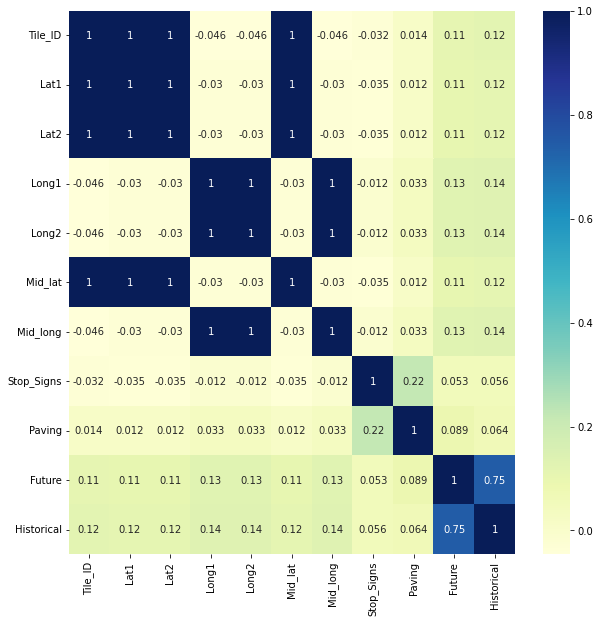

In [74]:
# plotting correlation heatmap
fig, ax = mp.subplots(figsize=(10,10)) 
dataplot = sns.heatmap(tiles.corr(), cmap="YlGnBu", annot=True)

<ipython-input-71-8ee179e018ba>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


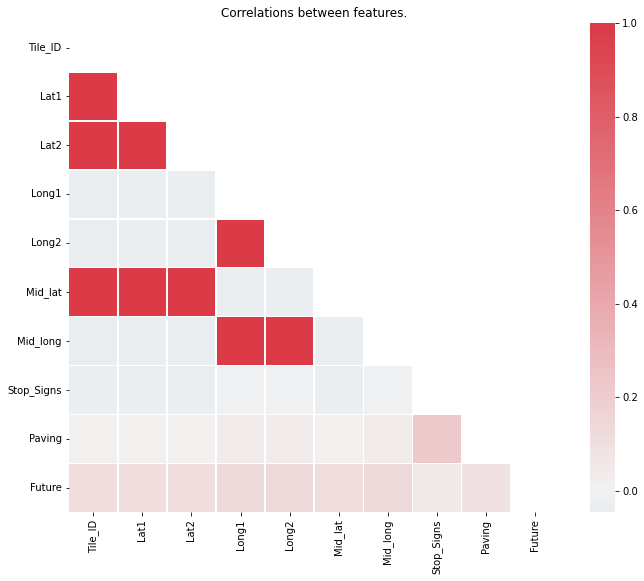

In [71]:
corr = tiles[columns_all[:-1]].corr()
fig, ax = mp.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
mp.title("Correlations between features.")
mp.show()

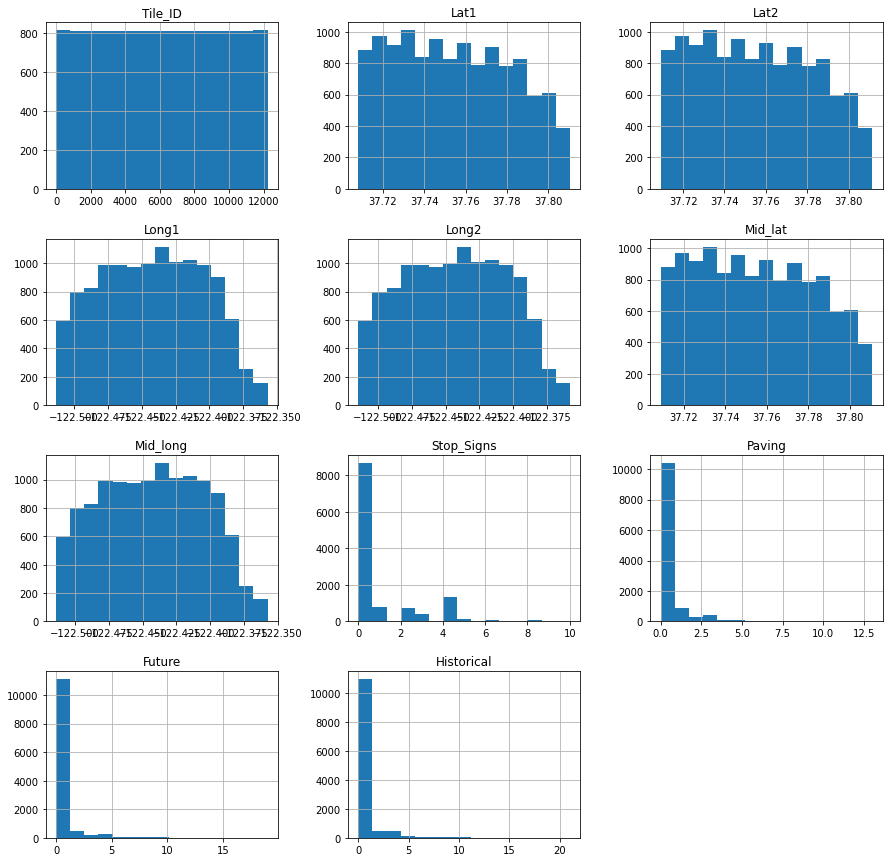

In [81]:
tiles[columns_all[:]].hist(figsize=(15,15), bins=15)
mp.show()

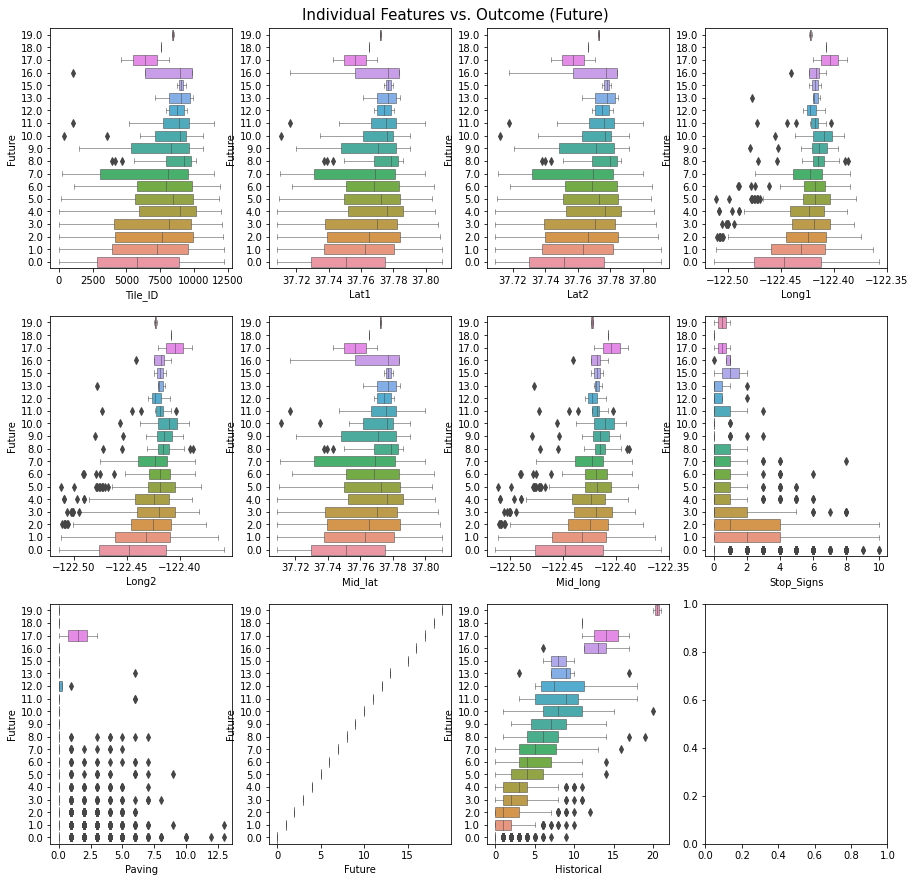

In [87]:
fig, ax_grid = mp.subplots(3, 4, figsize=(15,15))
y = tiles['Future']
for idx, feature in enumerate(columns_all[:]):
    x = tiles[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//4][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (Future)", fontsize=15, y=0.9)
mp.show()